# Imports

In [196]:
# common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# textblob packages
import re
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

# nlp packages
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [76]:
nltk.download('punkt')
SENT_DETECTOR = nltk.data.load('tokenizers/punkt/french.pickle')
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AudreyPOINSOT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AudreyPOINSOT\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AudreyPOINSOT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# data
path = 'data/'
data_df = pd.read_excel(path + 'datacraft_data_vaccination_5g_2021_05_11.xlsx', sheet_name='Sheet1')

In [84]:
data_df.tweet_date = pd.to_datetime(data_df.tweet_date) # format='YYYY-mm-dd hh:mm:sss'

In [172]:
retweeted_status_id_list = list(data_df['retweeted_status_id'].unique())
data_df[data_df['status_id'].isin(retweeted_status_id_list)].shape

(12393, 17)

# I- Exploration

In [85]:
data_df.head()

,pseudo,tweet,tweet_date,tweet_mentions,status_id,tweet_formatted,is_rt,retweeted_status_id,retweeted_screen_name,geo_coords,description,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,tweet_cleaned
0,(Mysteriously Unnamed),@Cheewyy4 @AiphanMarcel @nonopp4 Quand il t' i...,2020-04-05 20:21:03,Cheewyy4| nonopp4,1246895646730260488,@cheewyy4 @aiphanmarcel @nonopp4 quand il t im...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,quand il t imposera son vaccin et sa puce ....
1,_________adaa,@umut_dkr Je t’explique : dans ce soie disant ...,2020-11-12 15:03:13,umut_dkr,1326903382662127622,@umut_dkr je t explique : dans ce soie disant ...,False,NaN,NaN,NA NA,De passage 🙃,729.0,431.0,0.0,3347.0,4165.0,2020-03-27 17:58:56,je t explique dans ce soie disant vaccin il y...
2,______Stan_____,RT @laurentchemla Quelqu'un a déjà réussi à fa...,2021-01-13 14:37:39,laurentchemla,1349364994165633024,rt @laurentchemla quelqu un a deja reussi a fa...,True,1.349346e+18,laurentchemla,NA NA,Dolce Vita à Marseille. \nDiffuseur de bon pla...,509.0,468.0,22.0,18153.0,11004.0,2014-10-26 13:18:03,rt quelqu un a deja reussi a faire tourner doo...
3,_____Aurore,RT @Lola__bos POITIERS je suis nounou pour ce ...,2020-10-13 05:07:59,Lola__bos,1315881950004088833,rt @lola__bos poitiers je suis nounou pour ce ...,True,1.315695e+18,Lola__bos,NA NA,twitter is dark and full of spoilers.,475.0,353.0,12.0,66194.0,2097.0,2012-01-07 17:21:43,rt poitiers je suis nounou pour ce potit chat ...
4,_____ilham,RT @MikeStnm_ Moi quand le gouvernement contrô...,2020-11-13 00:09:38,MikeStnm_,1327040891404611586,rt @mikestnm_ moi quand le gouvernement contro...,True,1.326938e+18,MikeStnm_,NA NA,Open up ur soul show me how its fake,37.0,94.0,0.0,1265.0,1443.0,2016-11-24 19:22:51,rt moi quand le gouvernement controlera mon es...


In [86]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193209 entries, 0 to 193208
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pseudo                 193209 non-null  object        
 1   tweet                  193209 non-null  object        
 2   tweet_date             193209 non-null  datetime64[ns]
 3   tweet_mentions         166889 non-null  object        
 4   status_id              193209 non-null  int64         
 5   tweet_formatted        193209 non-null  object        
 6   is_rt                  193209 non-null  bool          
 7   retweeted_status_id    124297 non-null  float64       
 8   retweeted_screen_name  123277 non-null  object        
 9   geo_coords             185107 non-null  object        
 10  description            133987 non-null  object        
 11  followers_count        185107 non-null  float64       
 12  friends_count          185107 non-null  floa

In [87]:
columns_to_keep = ['pseudo',
                   'tweet_date',
                   'tweet_mentions',
                   'status_id',
                   'tweet_formatted',
                   'is_rt',
                   'retweeted_status_id',
                   'retweeted_screen_name',
                   'geo_coords',
                   'description',
                   'followers_count',
                   'friends_count',
                   'listed_count',
                   'statuses_count',
                   'favourites_count',
                   'account_created_at']

data_df = data_df[columns_to_keep]

# II- Sentiment analysis

## II-1- Textblob

### II-1-a- test de la librairie

In [88]:
tweet = "Acheter des vêtements ça rend grave heureux en vrai."
TextBlob(tweet, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment

(0.38333333333333336, 0.5)

TextBlob().sentiment returns a tuple (sentiment_polarity, sentiment_subjectivity)
- sentiment_polarity between -1 and 1
- sentiment_subjectivity batween 0 and 1

In [89]:
help(TextBlob)

Help on class TextBlob in module textblob.blob:

class TextBlob(BaseBlob)
 |  TextBlob(text, tokenizer=None, pos_tagger=None, np_extractor=None, analyzer=None, parser=None, classifier=None, clean_html=False)
 |  
 |  A general text block, meant for larger bodies of text (esp. those
 |  containing sentences). Inherits from :class:`BaseBlob <BaseBlob>`.
 |  
 |  :param str text: A string.
 |  :param tokenizer: (optional) A tokenizer instance. If ``None``, defaults to
 |      :class:`WordTokenizer() <textblob.tokenizers.WordTokenizer>`.
 |  :param np_extractor: (optional) An NPExtractor instance. If ``None``,
 |      defaults to :class:`FastNPExtractor() <textblob.en.np_extractors.FastNPExtractor>`.
 |  :param pos_tagger: (optional) A Tagger instance. If ``None``, defaults to
 |      :class:`NLTKTagger <textblob.en.taggers.NLTKTagger>`.
 |  :param analyzer: (optional) A sentiment analyzer. If ``None``, defaults to
 |      :class:`PatternAnalyzer <textblob.en.sentiments.PatternAnalyzer>`.


In [90]:
help(TextBlob.polarity)

Help on cached_property in module textblob.decorators:

<textblob.decorators.cached_property object>


### II-1-b- Preprocessing des tweets

In [91]:
"""# cleaning laure

def clean (text):
    tokenized = word_tokenize(text) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('french')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

# Apply to all texts
df['tweet'] = df['tweet'].apply(clean)
# La fonction clean renvoyant une liste, je transforme cette liste en string
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(map(str, x)))"""

"# cleaning laure\n\ndef clean (text):\n    tokenized = word_tokenize(text) # Tokenize\n    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers\n    stop_words = set(stopwords.words('french')) # Make stopword list\n    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words\n    lemma=WordNetLemmatizer() # Initiate Lemmatizer\n    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize\n    return lemmatized\n\n# Apply to all texts\ndf['tweet'] = df['tweet'].apply(clean)\n# La fonction clean renvoyant une liste, je transforme cette liste en string\ndf['tweet'] = df['tweet'].apply(lambda x: ' '.join(map(str, x)))"

**Idées**:
- pour ne pas garder "@truc_muche" mais quand même garder l'information qu'il s'agit d'un autre utilisateur on pourrait remplacer ces tokens par des noms propres ou au moins des tokens qui seraient identifiés comme tels

In [92]:
def nlp_pipeline(text,with_account_ref=True):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"\@", "", text) if with_account_ref else re.sub(r"\@\S+\s", "", text)
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"[,\!\?\%\(\)\/\"]", "", text)
    text = re.sub(r"\&\S*\s", "", text)
    text = re.sub(r"\&", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\£", "", text)
    text = re.sub(r"\%", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\-", "", text)
    return text

# other pattern "(@.*?\\s{1})" and "http.*?\\s|http.*?$"

In [93]:
# tests sur le preprocessing

corpus = data_df['tweet_formatted']
corpus_clean = corpus.apply(lambda text:nlp_pipeline(text,with_account_ref=False))
corpus_clean.iloc[100]

'bill gates ne veut pas injecter de puce mais il a quand mm depose un brevet. brevet n°  wohttpst.copbuqoxhsfq  = la date. ohhh complotiste'

In [94]:
# tests sur le preprocessing

data_df['tweet_formatted'].iloc[100]

'bill gates ne veut pas injecter de puce, mais il a quand mm depose un brevet. brevet n° 60606 (wo/2020/060606)https://t.co/pbuqoxhsfq (2020 = la date). ohhh complotiste!!!!!!'

In [95]:
# apply preprocessing

data_df['tweet_cleaned'] = data_df['tweet_formatted'].apply(lambda text:nlp_pipeline(text,with_account_ref=False))

#### II-1-c- Apply textblog

In [175]:
def compute_sentiment(text):
    sentiment_polarity, sentiment_subjectivity = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
    return {'sentiment_polarity':sentiment_polarity,'sentiment_subjectivity':sentiment_subjectivity}


data_df_new = data_df.merge(data_df.apply(lambda row:pd.Series(compute_sentiment(text=row['tweet_cleaned'])),axis=1),left_index=True,right_index=True)
data_df_new.head()

,pseudo,tweet_date,tweet_mentions,status_id,tweet_formatted,is_rt,retweeted_status_id,retweeted_screen_name,geo_coords,description,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,tweet_cleaned,sentiment_polarity,sentiment_subjectivity
0,(Mysteriously Unnamed),2020-04-05 20:21:03,Cheewyy4| nonopp4,1246895646730260488,@cheewyy4 @aiphanmarcel @nonopp4 quand il t im...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,quand il t imposera son vaccin et sa puce ....,0.000,0.00
1,_________adaa,2020-11-12 15:03:13,umut_dkr,1326903382662127622,@umut_dkr je t explique : dans ce soie disant ...,False,NaN,NaN,NA NA,De passage 🙃,729.0,431.0,0.0,3347.0,4165.0,2020-03-27 17:58:56,je t explique dans ce soie disant vaccin il y...,0.049,0.21
2,______Stan_____,2021-01-13 14:37:39,laurentchemla,1349364994165633024,rt @laurentchemla quelqu un a deja reussi a fa...,True,1.349346e+18,laurentchemla,NA NA,Dolce Vita à Marseille. \nDiffuseur de bon pla...,509.0,468.0,22.0,18153.0,11004.0,2014-10-26 13:18:03,rt quelqu un a deja reussi a faire tourner doo...,-0.200,-0.40
3,_____Aurore,2020-10-13 05:07:59,Lola__bos,1315881950004088833,rt @lola__bos poitiers je suis nounou pour ce ...,True,1.315695e+18,Lola__bos,NA NA,twitter is dark and full of spoilers.,475.0,353.0,12.0,66194.0,2097.0,2012-01-07 17:21:43,rt poitiers je suis nounou pour ce potit chat ...,0.092,0.30
4,_____ilham,2020-11-13 00:09:38,MikeStnm_,1327040891404611586,rt @mikestnm_ moi quand le gouvernement contro...,True,1.326938e+18,MikeStnm_,NA NA,Open up ur soul show me how its fake,37.0,94.0,0.0,1265.0,1443.0,2016-11-24 19:22:51,rt moi quand le gouvernement controlera mon es...,0.200,0.30


In [213]:
data_df_new.shape

(193209, 19)

In [176]:
data_df_new[['sentiment_polarity','sentiment_subjectivity']].describe()

,sentiment_polarity,sentiment_subjectivity
count,193209.000000,193209.000000
mean,0.045798,0.228072
std,0.186863,0.710816
min,-1.000000,-0.800000
25%,0.000000,0.000000
50%,0.000000,0.150000
75%,0.145000,0.316667
max,1.000000,17.650000


In [177]:
data_df_new['sentiment_subjectivity'][data_df_new['sentiment_subjectivity']<0].count()

5644

In [178]:
data_df_new['sentiment_subjectivity'][data_df_new['sentiment_subjectivity']>1].count()

901

In [214]:
# delete strange subjectivity
data_df_new_filtered = data_df_new[(data_df_new['sentiment_subjectivity']>=0)&(data_df_new['sentiment_subjectivity']<=1)]
data_df_new_filtered.shape

(186664, 19)

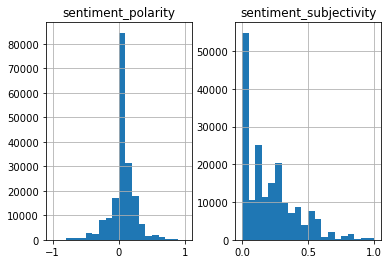

In [180]:
hist = data_df_new_filtered[['sentiment_polarity','sentiment_subjectivity']].hist(bins=20)

## II- Analyse de la viralité
### II-1- KPI computation

In [237]:
columns_to_keep_2 = ['pseudo',
                   'tweet_date',
                   'status_id',
                   'is_rt',
                   'retweeted_status_id',
                   'account_created_at',
                    'tweet_cleaned',
                    'sentiment_polarity',
                    'sentiment_subjectivity']

data_to_group_by = data_df_new_filtered[columns_to_keep][pd.notnull(data_df_new_filtered['retweeted_status_id'])]
#data_to_group_by['retweeted_status_id'] = data_to_group_by['retweeted_status_id'].astype('int64')
data_to_group_by.shape

(119338, 16)

In [240]:
# nombre de fois qu'un tweet est retweeté
retweet_count = data_to_group_by[['retweeted_status_id','status_id']].groupby('retweeted_status_id').agg('count').reset_index()
retweet_count.columns = ['status_id', 'count']
retweet_count.describe()

,status_id,count
count,1.457900e+04,14579.000000
mean,1.301332e+18,8.185609
std,4.086934e+16,35.173657
min,3.034768e+17,1.000000
25%,1.262107e+18,1.000000
50%,1.301179e+18,2.000000
75%,1.335672e+18,4.000000
max,1.366174e+18,1421.000000


In [241]:
retweet_count['status_id'].nunique()

14579

In [242]:
# duréee entre premier et dernier retweet
data_to_group_by_date = data_to_group_by[['retweeted_status_id','tweet_date']]
data_to_group_by_date['tweet_date_2'] = data_to_group_by_date['tweet_date']
retweet_first_date_last_date = data_to_group_by_date.groupby('retweeted_status_id').agg({'tweet_date' : 'min', 'tweet_date_2' : 'max'}).reset_index()

retweet_first_date_last_date['delta_time'] = retweet_first_date_last_date['tweet_date_2'] - retweet_first_date_last_date['tweet_date']
retweet_first_date_last_date['delta_time'] = retweet_first_date_last_date['delta_time'].apply(lambda td:td.seconds)
retweet_first_date_last_date = retweet_first_date_last_date[['retweeted_status_id','delta_time']]
retweet_first_date_last_date.columns = ['status_id', 'delta_time']
retweet_first_date_last_date.describe()

<ipython-input-242-a81e77670973>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_group_by_date['tweet_date_2'] = data_to_group_by_date['tweet_date']


,status_id,delta_time
count,1.457900e+04,14579.000000
mean,1.301332e+18,15263.781809
std,4.086934e+16,23872.983330
min,3.034768e+17,0.000000
25%,1.262107e+18,0.000000
50%,1.301179e+18,350.000000
75%,1.335672e+18,24223.000000
max,1.366174e+18,86385.000000


In [243]:
retweet_first_date_last_date.head()

,status_id,delta_time
0,3.034768e+17,0
1,6.154432e+17,0
2,6.351336e+17,0
3,8.267312e+17,83504
4,8.756962e+17,0


In [244]:
retweet_first_date_last_date[retweet_first_date_last_date['delta_time']>0].describe()

,status_id,delta_time
count,7.654000e+03,7654.000000
mean,1.302320e+18,29073.775150
std,3.896757e+16,26154.604957
min,8.267312e+17,1.000000
25%,1.263062e+18,4915.250000
50%,1.301875e+18,21846.500000
75%,1.336967e+18,49553.250000
max,1.366109e+18,86385.000000


In [245]:
# le nombre d'utilisateurs différents ayant retweetés
retweet_user_distinct = data_to_group_by[['retweeted_status_id','status_id']].groupby('retweeted_status_id').agg(pd.Series.nunique).reset_index()
retweet_user_distinct.describe()

,retweeted_status_id,status_id
count,1.457900e+04,14579.000000
mean,1.301332e+18,8.185609
std,4.086934e+16,35.173657
min,3.034768e+17,1.000000
25%,1.262107e+18,1.000000
50%,1.301179e+18,2.000000
75%,1.335672e+18,4.000000
max,1.366174e+18,1421.000000


**Remarque**: idem que count donc on oublie

### II-2- Merge des KPIs

In [246]:
# check number fo tweets corresponding between data_df_new and retweeted_status_id_list
retweeted_status_id_list = list(data_to_group_by['retweeted_status_id'].unique())
data_df_new_filtered[data_df_new_filtered['status_id'].isin(retweeted_status_id_list)].shape

(12020, 19)

In [267]:
first_merge = retweet_first_date_last_date.merge(retweet_count, how='left', on="status_id")
first_merge['status_id'].nunique()

14579

In [275]:
# check number fo tweets corresponding between data_df_new and retweeted_status_id_list
retweeted_status_id_list = list(first_merge['status_id'].unique())
data_df_new_filtered[data_df_new_filtered['status_id'].isin(retweeted_status_id_list)].shape

(12020, 19)

In [279]:
# PB HERE
data_df_to_explore = pd.merge(data_df_new_filtered, first_merge, how='left', on='status_id')
columns_to_keep_3 = ['status_id',
                     'sentiment_polarity',
                    'sentiment_subjectivity',
                    'delta_time',
                    'count'] # 'status_id',

data_df_to_explore = data_df_to_explore[columns_to_keep_3]
data_df_to_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186664 entries, 0 to 186663
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status_id               186664 non-null  int64  
 1   sentiment_polarity      186664 non-null  float64
 2   sentiment_subjectivity  186664 non-null  float64
 3   delta_time              4672 non-null    float64
 4   count                   4672 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 8.5 MB


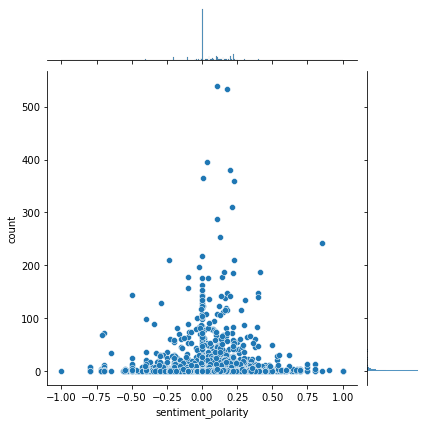

In [280]:
sns.jointplot(x=data_df_to_explore['sentiment_polarity'], y=data_df_to_explore['count'])

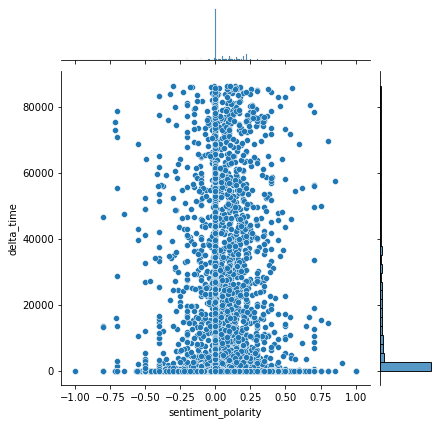

In [249]:
sns.jointplot(x=data_df_to_explore['sentiment_polarity'], y=data_df_to_explore['delta_time'])

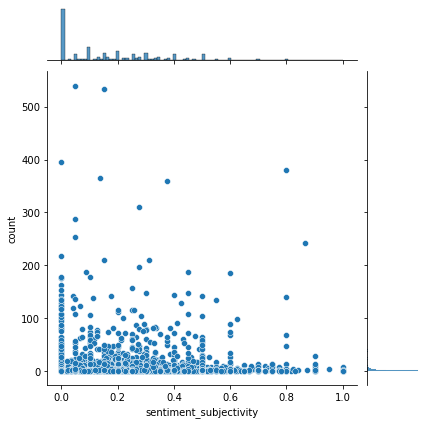

In [250]:
sns.jointplot(x=data_df_to_explore['sentiment_subjectivity'], y=data_df_to_explore['count'])

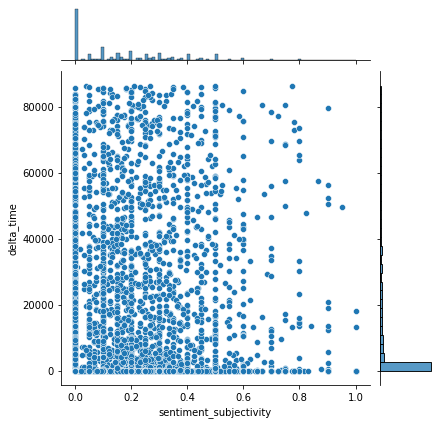

In [251]:
sns.jointplot(x=data_df_to_explore['sentiment_subjectivity'], y=data_df_to_explore['delta_time'])

**Commentaires**:
- pas tres polarisé donc pas exploitable telquel
- mais a cleaner a croiser à d'autres données comme topic et community